In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

df = pd.read_csv('dataset.csv')

df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='any')

df.drop(['encounter_id', 'patient_id', 'icu_id', 'hospital_id', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], axis=1, inplace=True)

dummies = pd.get_dummies(df[['icu_admit_source', 'ethnicity', 'gender',  'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_type', 'icu_stay_type']])
df = pd.concat([df, dummies], axis=1)
df.drop(['icu_admit_source', 'ethnicity', 'gender',  'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_type', 'icu_stay_type'], axis=1, inplace=True)

df.to_csv('dataset_encoded.csv', index=False)

# read the CSV file into a Pandas DataFrame
df = pd.read_csv('dataset_encoded.csv')

# separate features and labels
X = df.drop('hospital_death', axis=1)
y = df['hospital_death']

smote = SMOTE(sampling_strategy='minority', random_state=42)

# apply SMOTE oversampling to the entire dataset where y = 1
X_resampled, y_resampled = smote.fit_resample(X, y)

# concatenate the resampled minority class with the majority class
X_resampled = pd.concat([X[y == 0], pd.DataFrame(X_resampled)], axis=0)
y_resampled = pd.concat([y[y == 0], pd.Series(y_resampled)], axis=0)

# combine the resampled features and labels back into a DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# write the resampled data to a new CSV file
df_resampled.to_csv('smote_dataset.csv', index=False)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import nltk

df = pd.read_csv('smote_dataset.csv')
print(df.shape)

(156132, 116)


In [4]:
# dropping empty columbs
df = df.dropna(axis=1, how='all')

#drop rows with missing values
df = df.dropna(axis=0, how='any')
print(df.describe())

                 age            bmi  elective_surgery         height   
count  156132.000000  156132.000000     156132.000000  156132.000000  \
mean       64.338020      28.948442          0.128404     169.779661   
std        15.704077       7.983313          0.334540      10.234609   
min        16.000000      14.844926          0.000000     137.200000   
25%        55.000000      23.619066          0.000000     162.600000   
50%        67.000000      27.461224          0.000000     170.100000   
75%        76.146708      32.541395          0.000000     177.800000   
max        89.000000      67.814990          1.000000     195.590000   

       pre_icu_los_days         weight  apache_2_diagnosis   
count     156132.000000  156132.000000       156132.000000  \
mean           0.964958      83.436212          175.633896   
std            2.506233      24.110755           84.186391   
min           -0.244444      38.600000          101.000000   
25%            0.047714      67.000000   

In [5]:

print(df.shape)

(156132, 116)


In [ ]:
df.drop(['encounter_id', 'patient_id', 'icu_id', 'hospital_id', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], axis=1, inplace=True)

In [16]:
# one hot encode the categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

dummies = pd.get_dummies(df[['icu_admit_source', 'ethnicity', 'gender',  'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_type', 'icu_stay_type']])
# concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df, dummies], axis=1)
# drop the original categorical columns
df.drop(['icu_admit_source', 'ethnicity', 'gender',  'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_type', 'icu_stay_type'], axis=1, inplace=True)
print(df.columns)

Index(['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days',
       'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache',
       ...
       'icu_type_CSICU', 'icu_type_CTICU', 'icu_type_Cardiac ICU',
       'icu_type_MICU', 'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU',
       'icu_type_SICU', 'icu_stay_type_admit', 'icu_stay_type_readmit',
       'icu_stay_type_transfer'],
      dtype='object', length=116)


In [6]:
# removing outliers using z-score
import pandas as pd
from scipy.stats import zscore

# Calculate z-scores for each feature
z_scores = df.apply(zscore)

# # Identify outliers by setting a threshold for z-score
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# # Remove outliers from DataFrame
df = df[~outliers]
print(df.shape)

(43903, 116)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
# import the xgboost classifier
from xgboost import XGBClassifier


# Load the iris dataset
X, y = df.drop(['hospital_death'], axis=1), df['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xg = XGBClassifier()

# Define the sequential feature selector with forward selection
sfs = SequentialFeatureSelector(xg, n_features_to_select=5, direction='forward')

# Fit the sequential feature selector to the training data
sfs.fit(X_train, y_train)

print("Selected features:", df.feature_names[sfs.get_support()])
print("Model score:", sfs.score(X_test, y_test))


In [68]:
# get df feature names
feature_names = df.columns.tolist()
print("Selected features:", sfs.get_support())


# go through each feature and print the name and whether it was selected
for i in range(len(sfs.get_support())):
    if sfs.get_support()[i]:
        print(feature_names[i])


Selected features: [False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False False False False  True False  True False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
resprate_apache
temp_apache
d1_resprate_min
d1_spo2_min
h1_resprate_min


In [7]:
# train test split
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(df.drop(['hospital_death'], axis=1), df['hospital_death'], test_size=0.2, random_state=42)

In [8]:
# trying all of the above preprocessing steps with balanced except  PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
#import log loss
from sklearn.metrics import log_loss


param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'reg_alpha': [ 0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

xgb_model = xgb.XGBClassifier()

grid_search = HalvingGridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 10)
grid_search.fit(X_train, y_train)

#make predictions for test data
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 48
max_resources_: 35122
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1296
n_resources: 48
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV 5/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 3/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 2/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 1/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 4/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 2/5; 2/1296] START colsample_b

In [9]:
# get an X_test and y_test 1/3 of tehe original size
# X_test = X_test[:int(len(X_test)/3)]
# y_test = y_test[:int(len(y_test)/3)]

y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]


In [10]:
print(grid_search.best_params_)
xgb_model = xgb.XGBClassifier(**grid_search.best_params_)

log_loss = log_loss(y_test, y_pred_proba)
print("Log Loss: %.2f%%" % (log_loss * 100.0))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: %.2f%%" % (auc * 100.0))

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 1}
Log Loss: 9.39%
Accuracy: 97.05%
AUC: 98.70%


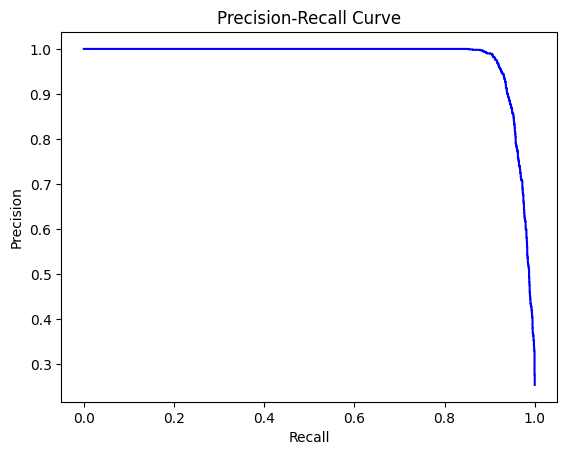

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# assuming that you have already defined your model and made predictions
# on a test set and stored them in the variables y_true and y_pred

# calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# plot the curve
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()# show

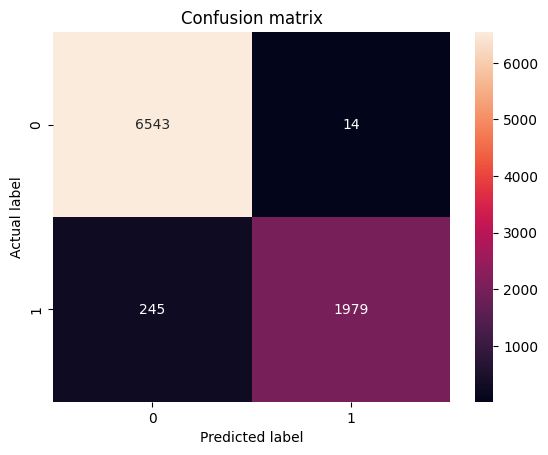

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

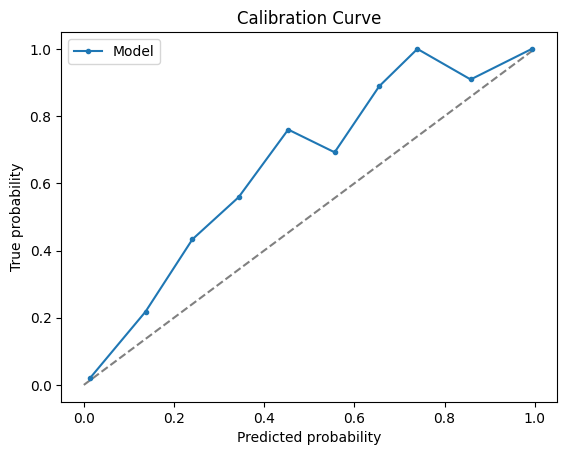

In [16]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# assuming you have already trained a model and generated predicted probabilities for X_test
y_prob = grid_search.predict_proba(X_test)[:, 1]

# calculate the calibration curve
true_prob, pred_prob = calibration_curve(y_test, y_prob, n_bins=10)

# plot the calibration curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.plot(pred_prob, true_prob, marker='.', label='Model')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()


AUC: 0.99


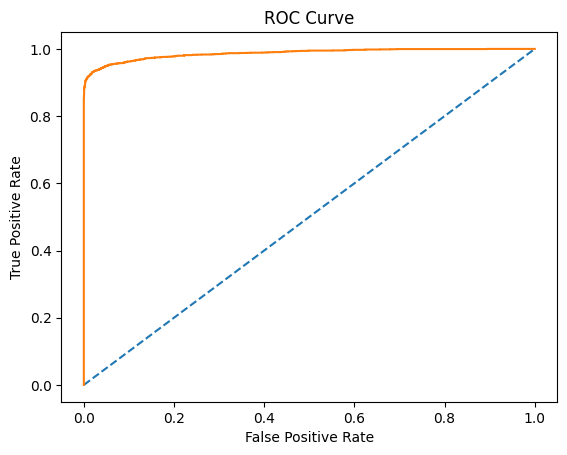

In [19]:
# plot ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.2f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr)
# show the plot
# label axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [26]:
# train test split
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X_transformed, df['hospital_death'], test_size=0.2, random_state=42)

In [27]:
# prepreocessing with PCA and outliers
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
#import log loss
from sklearn.metrics import log_loss


param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'reg_alpha': [ 0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

xgb_model = xgb.XGBClassifier()

grid_search = HalvingGridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 10)
grid_search.fit(X_train, y_train)

#make predictions for test data
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 41
max_resources_: 30315
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1296
n_resources: 41
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV 1/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 1/5; 1/1296] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5;, score=(train=0.719, test=0.625) total time=   0.0s
[CV 2/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 3/5; 1/1296] START colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5
[CV 2/5; 1/1296] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1,

In [28]:
print(grid_search.best_params_)
xgb_model = xgb.XGBClassifier(**grid_search.best_params_)

log_loss = log_loss(y_test, y_pred_proba)
print("Log Loss: %.2f%%" % (log_loss * 100.0))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: %.2f%%" % (auc * 100.0))


{'colsample_bytree': 1, 'learning_rate': 1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.5}
Log Loss: 16.94%
Accuracy: 94.84%
AUC: 98.27%


In [84]:
import shap

xgb_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [85]:
print(shap_values)

[[ 4.2931432e-01  8.9135706e-02  2.3163117e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.1536298e-01  3.7974622e-02  5.4570584e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2842410e-01 -2.4341354e-02  2.2652291e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-6.9757596e-02 -5.8041118e-02  1.7317552e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.6297068e-01 -1.3506389e-01  1.8148045e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.2157301e-01  8.2569927e-02  1.1447202e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


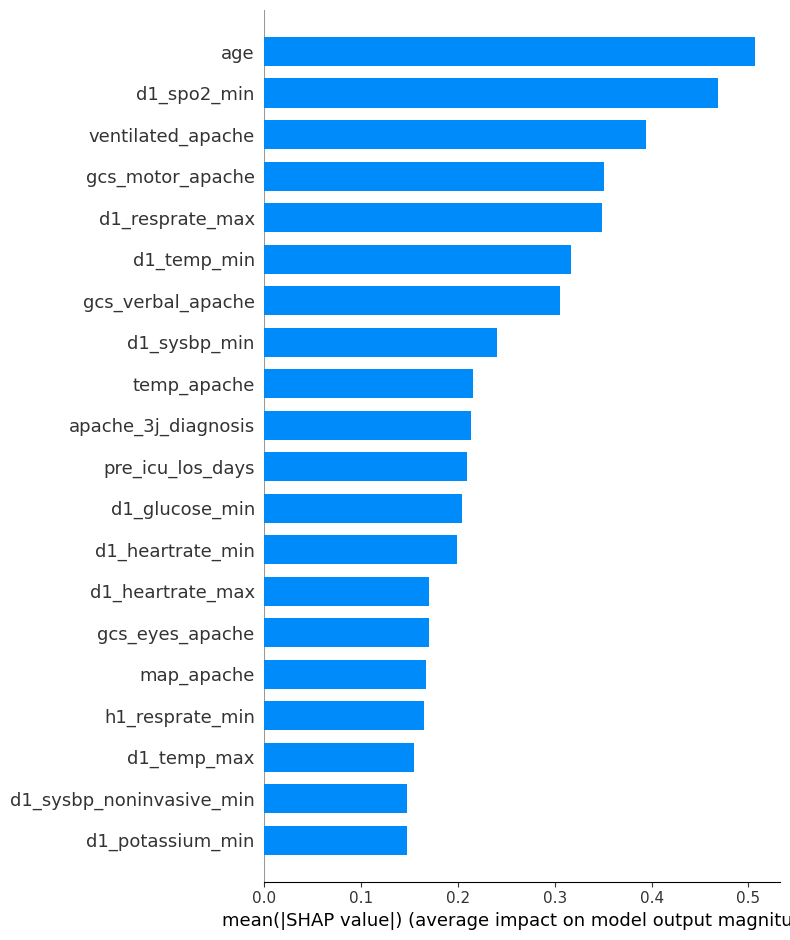

In [86]:
shap.summary_plot(shap_values, X_test, plot_type='bar')